# **Correlator of Lorentz force felt by heavy quarks immersed in the Glasma**

## Default simulation parameters for the Glasma and the Wong solvers

In [1]:
import numpy as np

# Define hbar * c in units of GeV * fm
hbarc = 0.197326 

# General parameters
su_group = 'su3'        # Gauge group

# Simulation box parameters
L = 10      # Length of simulation box [fm]
N = 512     # Number of lattice sites
tau_sim = 0.3     # Simulation time [fm/c]
DTS = 8     # Time step

# MV model parameters
Qs = 2              # Saturation momentum [GeV]	
ns = 50     # Number of color sheets
factor = 0.8        # Ratio between Qs/g^2\mu for Ns = 50 color sheets
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))           # Running coupling constant		
mu = Qs / (g**2 * factor)           # MV model parameter	
ir = 0.1 * g**2 * mu         # Infrared regulator [GeV]
uv = 10.0           # Ultraviolet regulator [GeV]

# Heavy quark related parameters, chosen here for a charm quark
quark = 'charm'     # Quark type
mass = 1.27      # Heavy quark mass [GeV]
tau_form = 1/(2*mass)*hbarc     # Formation time [fm/c]
pT = 0.5    # Initial transverse momentum [GeV]
ntp = 100000   # Number of test particles

# Other numerical parameters
nevents = 1    # Number of Glasma events
folder = 'corr_' + su_group + '_pT_' + str(pT) + '_' + quark       # Results folder

# Store relevant parameters in a dictionary
p = {
    'QUARK': quark,
    'MASS': mass,           
    'TFORM': tau_form,       
    'PT': pT,          
    'FOLDER': folder,         
    }

## Set environment variables and import all relevant modules

In [2]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False
from curraun.fields_correlators import FieldsCorrelators
# Wong modules
from curraun import wong
wong.DEBUG = False
wong.REPRESENTATION = 'fundamental'
wong.BOUNDARY = 'periodic'
from curraun.wong import init_charge
from curraun.wong_correlators import ForceCorrelators
import curraun.kappa_wong as kappa_wong
import curraun.kappa as kappa

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

Using CUDA
Using SU(3)
Using double precision
Using double precision


## Simulation routine for computing correlators of Glasma electric and magnetic fields

In [3]:
import pickle
from tqdm import tqdm

# Path where results are saved
current_path = os.getcwd() 
results_folder = 'results'
if not os.path.isdir(results_folder):
    os.makedirs(results_folder)
os.chdir(current_path + '/' + results_folder)

# Simulation routine
def simulate(p, ev): 
    output = {}
    output["parameters"] = p.copy()

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(p['TFORM'] / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize Glasma fields correlators
    fieldscorr = FieldsCorrelators(s)

    tau, elcorr_T, elcorr_L, magcorr_T, magcorr_L  = np.zeros(maxt-formt), np.zeros(maxt-formt), np.zeros(maxt-formt), np.zeros(maxt-formt), np.zeros(maxt-formt)
    # [(GeV / fm) ** 2]
    units = (E0 ** 2 / hbarc) ** 2 

    with tqdm(total=maxt+1) as pbar:
        for t in range(maxt+1):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            if t==formt:  
                Eform = fieldscorr.compute_elfield()
                Bform = fieldscorr.compute_magfield()
            elif t>=formt:
                EformE = fieldscorr.compute_elcorr(Eform)
                ExformEx, EyformEy, EzformEz = EformE[0], EformE[1], EformE[2]
                elcorr_T[t-formt-1], elcorr_L[t-formt-1] = (ExformEx + EyformEy) * units, EzformEz * units

                BformB = fieldscorr.compute_magcorr(Bform)
                BxformBx, ByformBy, BzformBz = BformB[0], BformB[1], BformB[2]
                magcorr_T[t-formt-1], magcorr_L[t-formt-1] = (BxformBx + ByformBy) * units, BzformBz * units

                tau[t-formt-1] = t / DTS * a

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    # Save results to a specific folder
    corr_folder = p['FOLDER']
    if not os.path.isdir(corr_folder):
        os.makedirs(corr_folder)
    corr_path = current_path + '/' + results_folder + '/' + corr_folder + '/'
    os.chdir(corr_path)

    output['elcorr_T'], output['elcorr_L'], output['magcorr_T'], output['magcorr_L'], output['tau'] = elcorr_T, elcorr_L, magcorr_T, magcorr_L, tau
    filename = 'ev_' + str(ev+1) + '.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(output, handle)

    os.chdir(current_path + '/' + results_folder)

    return output

## Run over multiple Glasma events

In [ ]:
quarks = ['massive', 'beauty', 'charm']
quark_masses = [200, 4.18, 1.27]

elcorr_T, elcorr_L, magcorr_T, magcorr_L, tau = {}, {}, {}, {}, {}
for iq in range(len(quarks)):
    p['QUARK'], p['MASS'] = quarks[iq], quark_masses[iq]
    p['TFORM'] = 1/(2*p['MASS'])*hbarc 
    print(p['QUARK'].capitalize(), "quark")

    tag = quarks[iq]
    p['FOLDER'] = 'corr_' + su_group + '_' + quarks[iq]
    
    formt, maxt = int(p['TFORM'] / L * N * DTS), int(tau_sim / L * N * DTS)
    taus = np.linspace(p['TFORM'], tau_sim, maxt-formt)

    elcorrs_T, elcorrs_L, magcorrs_T, magcorrs_L = [], [], [], []
    for ev in range(nevents):
        output = simulate(p, ev)
        elcorrs_T.append(output['elcorr_T'])
        elcorrs_L.append(output['elcorr_L'])
        magcorrs_T.append(output['magcorr_T'])
        magcorrs_L.append(output['magcorr_L'])

    elcorr_T[tag], elcorr_L[tag] = np.mean(elcorrs_T, axis=0), np.mean(elcorrs_L, axis=0)
    magcorr_T[tag], magcorr_L[tag] = np.mean(magcorrs_T, axis=0), np.mean(magcorrs_L, axis=0)
    tau[tag] = taus

output = {}
output['quarks'], output['masses'] = quarks, quark_masses
output['elcorr_T'], output['elcorr_L'], output['magcorr_T'], output['magcorr_L'], output['tau'] = elcorr_T, elcorr_L, magcorr_T, magcorr_L, tau
filename = 'fields_correlators.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

## Plot the correlators of the Glasma electric fields

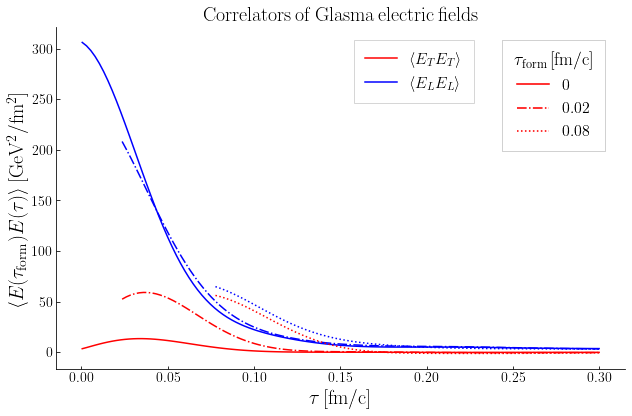

In [5]:
os.chdir(current_path)
data = pickle.load(open('results/fields_correlators.pickle', 'rb'))
elcorr_T, elcorr_L, tau = data['elcorr_T'], data['elcorr_L'], data['tau']
quarks = data['quarks']

import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({'font.size':14})

fig = plt.figure()
ax = plt.subplot()
plt.title(r'$\mathrm{Correlators\,of\,Glasma\,electric\,fields}$', size = 20)
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 20)
plt.ylabel(r'$\langle E(\tau_\mathrm{form})E(\tau)\rangle\,\mathrm{[GeV^2/fm^2]}$', size = 20)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(direction='in')

colors = ['red', 'blue']
linestyles = ['-', '-.', ':']
iq = 0
for tag in quarks:
    ax.plot(tau[tag], elcorr_T[tag], color=colors[0], linestyle=linestyles[iq])
    ax.plot(tau[tag], elcorr_L[tag], color=colors[1], linestyle=linestyles[iq])
    iq += 1

labels_comp = [r'$\langle E_TE_T\rangle$', r'$\langle E_LE_L\rangle$']
labels_quarks = [r'$0$', r'$0.02$', r'$0.08$']
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], labels_comp, loc = 'upper right', ncol=1, bbox_to_anchor=(0.74,0.97), fontsize='16')
legend1.get_frame().set_boxstyle('square')
legend1.get_title().set_fontsize('18')
ax.add_artist(legend1)
legend2 = plt.legend([lines[i] for i in [0, 2, 4]], labels_quarks, loc = 'upper right', ncol=1, bbox_to_anchor=(0.97,0.97), title=r'$\tau_\mathrm{form}\,\mathrm{[fm/c]}$', fontsize='16')
legend2.get_frame().set_boxstyle('square')
legend2.get_title().set_fontsize('18')
ax.add_artist(legend2)

plt.tight_layout()
plt.savefig('glasma_elfields_corr.png', dpi=300, transparent=False, facecolor='white')

## Simulation routine for evolving the Glasma & solving Wong's equations
Computes the correlator of Lorentz force.

In [5]:
# Path where results are saved
current_path = os.getcwd() 
results_folder = 'results'
if not os.path.isdir(results_folder):
    os.makedirs(results_folder)
os.chdir(current_path + '/' + results_folder)

# Simulation routine
def simulate(p, ev): 
    output = {}
    output["parameters"] = p.copy()

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(p['TFORM'] / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    pT = p['PT'] / E0
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 4)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    mass = p['MASS'] / E0 
    m = mass * np.ones(ntp)
    fcorr = ForceCorrelators(s, wong_solver, ntp)

    for i in range(ntp):
        # Positions
        xT = np.random.rand(2) * s.n
        x0 = [xT[0], xT[1], 0.0]
        # Momenta
        angle = 2*np.pi*np.random.rand(1)
        p0 = [0.0, pT * np.cos(angle), pT * np.sin(angle), 0.0]
        # Charges
        q0 = init_charge()

        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, m)

    corr_T, corr_L = np.zeros(maxt-formt), np.zeros(maxt-formt)
    # [(GeV / fm) ** 2]
    units = (E0 ** 2 / hbarc) ** 2 / g ** 2

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Solve Wong's equations
            if t>=formt:  
                wong_solver.evolve()
                # Compute the correlator
                fcorr.compute_lorentz_force()
                if t==formt:
                    f0 = fcorr.f.copy()
                f = fcorr.f.copy()
                w = wong_solver.w.copy()
                fcorr.compute_force_correlator(f0, f, w, "transported")
                corr_comp = fcorr.corr.copy()
                corr_T[t-formt] = np.mean(corr_comp[:, 0] + corr_comp[:, 1], axis=0) * units
                corr_L[t-formt] = np.mean(corr_comp[:, 2], axis=0) * units

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    # Save results to a specific folder
    wong_folder = p['FOLDER']
    if not os.path.isdir(wong_folder):
        os.makedirs(wong_folder)
    wong_path = current_path + '/' + results_folder + '/' + wong_folder + '/'
    os.chdir(wong_path)

    output['corr_T'], output['corr_L'] = corr_T, corr_L
    filename = 'ev_' + str(ev+1) + '.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(output, handle)

    os.chdir(current_path + '/' + results_folder)

    return output

## Run over multiple Glasma events
Run the Wong solver over multiple Glasma events, for various quarks and values of initial transverse momenta, afterwards perform averages and store the results to a dictionary. The masses for charm and beauty quarks are taken from [PDGLive](https://pdglive.lbl.gov/Viewer.action), the formation time is chosen as $\tau_\mathrm{form}=1/(2m_\mathrm{quark})$. 

In [ ]:
pTs = [0.5, 5.0, 10.0]

corr_T, corr_L, tau = {}, {}, {}
for iq in range(len(quarks)):
    p['QUARK'], p['MASS'] = quarks[iq], quark_masses[iq]
    p['TFORM'] = 1/(2*p['MASS'])*hbarc 
    print(p['QUARK'].capitalize(), "quark")

    for pT in pTs:
        print('Transverse momentum', pT, 'GeV')
        p['PT'] = pT
        tag = quarks[iq] + '_pT_' + str(pT)
        p['FOLDER'] = su_group + '_pT_' + str(pT) + '_' + quarks[iq]
        
        formt, maxt = int(p['TFORM'] / L * N * DTS), int(tau_sim / L * N * DTS)
        taus = np.linspace(p['TFORM'], tau_sim, maxt-formt)

        corrs_T, corrs_L = [], []
        for ev in range(nevents):
            output = simulate(p, ev)
            corrs_T.append(output['corr_T'])
            corrs_L.append(output['corr_L'])

        corr_T[tag], corr_L[tag] = np.mean(corrs_T, axis=0), np.mean(corrs_L, axis=0)
        tau[tag] = taus

output = {}
output['quarks'], output['pTs'], output['masses'] = quarks, pTs, quark_masses
output['corr_T'], output['corr_L'], output['tau'] = corr_T, corr_L, tau
filename = 'lorentz_force_correlators.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

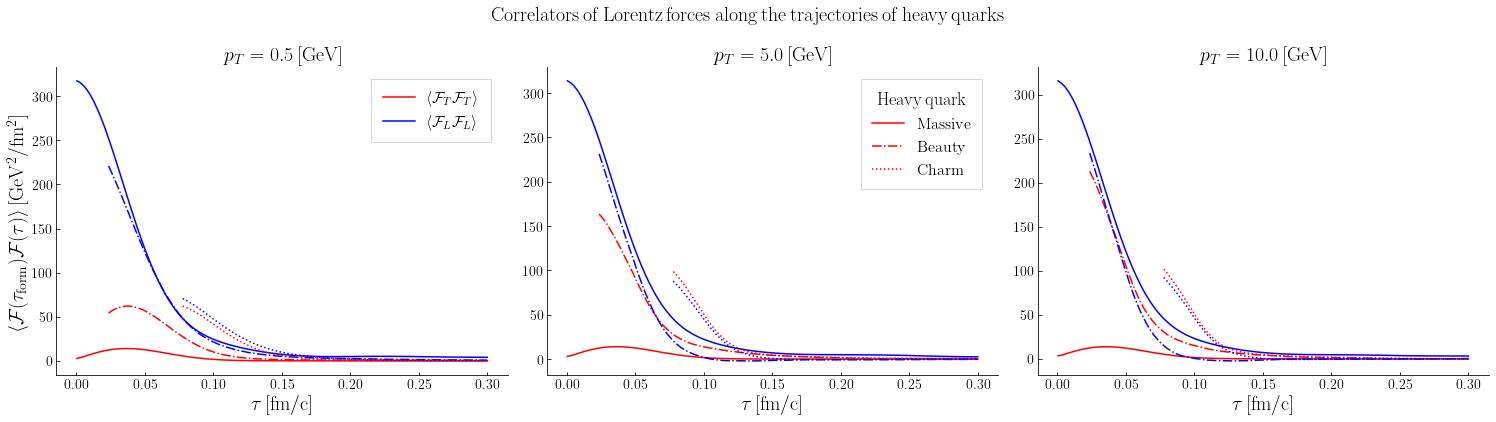

In [6]:
os.chdir(current_path)
data = pickle.load(open('results/lorentz_force_correlators.pickle', 'rb'))
corr_T, corr_L, tau = data['corr_T'], data['corr_L'], data['tau']
quarks, pTs = data['quarks'], data['pTs']

plt.rcParams["figure.figsize"] = (21, 6)
fig, ax = plt.subplots(1, 3)

colors = ['red', 'blue']
linestyles = ['-', '-.', ':']
titles = [r'$p_T=0.5\,\mathrm{[GeV]}$', r'$p_T=5.0\,\mathrm{[GeV]}$', r'$p_T=10.0\,\mathrm{[GeV]}$']

for ipT in range(len(pTs)):
    pT = pTs[ipT]
    for iq in range(len(quarks)):
        quark = quarks[iq]
        tag = quark + "_pT_" + str(pT)
        ax[ipT].plot(tau[tag], corr_T[tag], color=colors[0], linestyle=linestyles[iq])
        ax[ipT].plot(tau[tag], corr_L[tag], color=colors[1], linestyle=linestyles[iq])

        ax[ipT].spines["top"].set_visible(False)
        ax[ipT].spines["right"].set_visible(False)
        ax[ipT].tick_params(direction='in')

        ax[ipT].set_xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 20)
        ax[ipT].set_title(titles[ipT], size=20)

ax[0].set_ylabel(r'$\langle \mathcal{F}(\tau_\mathrm{form})\mathcal{F}(\tau)\rangle\,\mathrm{[GeV^2/fm^2]}$', size = 20)

labels_comp = [r'$\langle \mathcal{F}_T\mathcal{F}_T\rangle$', r'$\langle \mathcal{F}_L\mathcal{F}_L\rangle$']
labels_quarks = [r'$\mathrm{Massive}$', r'$\mathrm{Beauty}$', r'$\mathrm{Charm}$']
lines = ax[0].get_lines()
legend1 = ax[0].legend([lines[i] for i in [0, 1]], labels_comp, loc = 'upper right', ncol=1, bbox_to_anchor=(0.97,0.97), fontsize='16')
legend1.get_frame().set_boxstyle('square')
legend1.get_title().set_fontsize('18')
legend2 = ax[1].legend([lines[i] for i in [0, 2, 4]], labels_quarks, loc = 'upper right', ncol=1, bbox_to_anchor=(0.97,0.97), title=r'$\mathrm{Heavy\,quark}$', fontsize='16')
legend2.get_frame().set_boxstyle('square')
legend2.get_title().set_fontsize('18')

fig.suptitle(r'$\mathrm{Correlators\,of\,Lorentz\,forces\,along\,the\,trajectories\,of\,heavy\,quarks}$', size = 20)
plt.tight_layout()
plt.savefig('lorentz_force_corr.png', dpi=300, transparent=False, facecolor='white')

## Compute the decay times

In [7]:
import pickle
import scipy.optimize as opt

def exp_decay(tau, corr, tau_decay, const):
    return corr * np.exp(- tau / tau_decay) + const

correlators = pickle.load(open('results/lorentz_force_correlators.pickle', 'rb'))
quarks, pTs = correlators['quarks'], correlators['pTs']

tau_decays = {}
init_guess = (200, 0.02, 0.)

for quark in quarks:
    for pT in pTs:
        tag = quark + '_pT_' + str(pT)
        tau, corr = correlators['tau'][tag], correlators['corr_T'][tag] + correlators['corr_L'][tag]
        popt, pcov = opt.curve_fit(exp_decay, tau, corr, maxfev=10000, p0=init_guess)
        corr, tau_decay, const = popt
        tau_decays[tag] = tau_decay
        print(quark.capitalize(), "quark pT", pT, "decay time", tau_decay, "[fm/c]")

Massive quark pT 0.5 decay time 0.04705094239196628 [fm/c]
Massive quark pT 5.0 decay time 0.04639001945995542 [fm/c]
Massive quark pT 10.0 decay time 0.04618600945283945 [fm/c]
Beauty quark pT 0.5 decay time 0.04009187540046926 [fm/c]
Beauty quark pT 5.0 decay time 0.029022710431372535 [fm/c]
Beauty quark pT 10.0 decay time 0.026996426050100327 [fm/c]
Charm quark pT 0.5 decay time 0.03813409458365379 [fm/c]
Charm quark pT 5.0 decay time 0.024862630545585424 [fm/c]
Charm quark pT 10.0 decay time 0.024454588187239015 [fm/c]


## Recover the momentum broadening

In [85]:
# quark = 'massive'  
# p['MASS'] = 200      
quark = 'charm'  
p['MASS'] = 1.27    
p['TFORM'] = 1/(2*p['MASS'])*hbarc 
tau_sim = 1.0
p['pT'] = 10.0

from tqdm import tqdm

p['FOLDER'] = 'trial'
ev = 0

# Path where results are saved
current_path = os.getcwd() 
results_folder = 'results'
if not os.path.isdir(results_folder):
    os.makedirs(results_folder)
os.chdir(current_path + '/' + results_folder)

# Simulation routine
output = {}
output["parameters"] = p.copy()

# Derived parameters
a = L / N
E0 = N / L * hbarc
DT = 1.0 / DTS
formt = int(p['TFORM'] / a * DTS)
maxt = int(tau_sim / a * DTS)

# Initialize Glasma fields
s = core.Simulation(N, DT, g)
va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
initial.init(s, va, vb)

# Initialize the Wong solver
wong_solver = wong.WongSolver(s, ntp)
pT = p['PT'] / E0
x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 4)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
mass = p['MASS'] / E0 
m = mass * np.ones(ntp)
fcorr = ForceCorrelators(s, wong_solver, ntp)

for i in range(ntp):
    # Positions
    xT = np.random.rand(2) * s.n
    x0 = [xT[0], xT[1], 0.0]
    # Momenta
    angle = 2*np.pi*np.random.rand(1)
    p0 = [0.0, pT * np.cos(angle), pT * np.sin(angle), 0.0]
    # Charges
    q0 = init_charge()

    x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

wong_solver.initialize(x0s, p0s, q0s, m)

ws, fs = np.zeros((maxt-formt, ntp, su.GROUP_ELEMENTS)), np.zeros((maxt-formt, ntp, 3, su.GROUP_ELEMENTS))
# ts = round((maxt-formt)/DTS)
# ws, fs = np.zeros((ts+1, ntp, su.GROUP_ELEMENTS)), np.zeros((ts+1, ntp, 3, su.GROUP_ELEMENTS))

# fs = np.zeros((maxt-formt, ntp, 3, su.GROUP_ELEMENTS))
sigmapt_avg = np.zeros(maxt-formt)


with tqdm(total=maxt) as pbar:
    for t in range(maxt):
        # Evolve Glasma fields
        core.evolve_leapfrog(s)

        # Solve Wong's equations
        if t>=formt:  
            wong_solver.evolve()
            
            fcorr.compute_lorentz_force()
            fs[t-formt] = fcorr.f.copy()
            ws[t-formt] = wong_solver.w.copy()
            # fcorr.compute_lorentz_force_transported()
            # fs[t-formt] = fcorr.f.copy()

            # if t % DTS == 0:
            #     curr_t = round((t-formt)/DTS)

            #     fcorr.compute_lorentz_force()
            #     # fs[t-formt] = fcorr.f.copy()
            #     # ws[t-formt] = wong_solver.w.copy()

            #     fs[curr_t] = fcorr.f.copy()
            #     ws[curr_t] = wong_solver.w.copy()

            if t==formt:
                pmu0 = wong_solver.p.copy()
                px0, py0 = pmu0[:, 1], pmu0[:, 2]
            pmu = wong_solver.p.copy()
            px, py = pmu[:, 1], pmu[:, 2]
            sigmapt = (px-px0)**2 + (py-py0)**2
            sigmapt_avg[t-formt] = np.mean(sigmapt) * E0**2

        pbar.set_description("Event " + str(ev+1))
        pbar.update(1)


Event 1: 100%|██████████| 409/409 [03:02<00:00,  2.24it/s]


In [10]:
autocorr = np.zeros((ts+1, ntp, 3))
dt = 1/DTS

for ti in range(formt, maxt, DTS):
    print('ti=',ti)
    # ti_step = int((ti-formt)/step)
    ti_step = round((ti-formt)/DTS)
    # print(ti_step)
    autocorr_ti = 0
    for t0 in range(formt, ti, DTS):
        # print('t0=',t0)
        # t0_step =  int((t0-formt)/step)
        t0_step = round((t0-formt)/DTS)
        for t1 in range(formt, ti, DTS):
            # print('t1=',t1)
            # t1_step =  int((t1-formt)/step)
            t1_step = round((t1-formt)/DTS)
            fcorr.compute_lorentz_force_autocorrelator(fs[t0_step, :, :, :], fs[t1_step, :, :, :], ws[t0_step, :, :], ws[t1_step, :, :])
            # fcorr.compute_lorentz_force_autocorrelator(fs[t0, :, :, :], fs[t1, :, :, :], ws[t0, :, :], ws[t1, :, :])
            # fcorr.compute_lorentz_force_autocorrelator(fs[t0-formt, :, :, :], fs[t1-formt, :, :, :], ws[t0-formt, :, :], ws[t1-formt, :, :])
            # ft0ft1 = np.mean(fcorr.auto_corr.copy().real, axis=1)
            # autocorr_ti += ft0ft1[0] + ft0ft1[1]
            ft0ft1 = fcorr.auto_corr.copy().real
            # autocorr_ti += ft0ft1 * (step*dt)**2
            autocorr_ti += ft0ft1 * dt**2
    autocorr[ti_step] = autocorr_ti

autocorr_avg = np.mean(autocorr, axis=1)
autocorr_T = (autocorr_avg[:,0]+autocorr_avg[:,1])* E0**2
# print(autocorr_T)

ti= 31
ti= 39
ti= 47
ti= 55
ti= 63
ti= 71
ti= 79
ti= 87
ti= 95
ti= 103
ti= 111
ti= 119
ti= 127


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({'font.size':14})

fig = plt.figure()
ax = plt.subplot()

tau_corr = np.multiply(range(formt, maxt,step), a/DTS)
ax.plot(tau_corr, autocorr_T)
tau = np.multiply(range(formt, maxt, 1), a/DTS)
ax.plot(tau, sigmapt_avg)
# ax.set_ylim(0,1.5)

In [ ]:
step = 10
autocorr_t = np.zeros(((maxt-formt)//step+1, ntp, 3))

for t in range(formt, maxt, step):
    # print(t)
    sumprime = 0
    for tprime in range(formt, maxt, step):
        fcorr.compute_lorentz_force_autocorrelator(fs[t-formt, :, :, :], fs[tprime-formt, :, :, :], ws[t-formt, :, :], ws[tprime-formt, :, :])
        ft0ft1 = fcorr.auto_corr.copy().real
        sumprime += ft0ft1
    autocorr_t[(t-formt)//step] = sumprime
print(autocorr_t)



In [86]:
# step = 10
step = DTS
autocorr = np.zeros(((maxt-formt)//step+1, ntp, 3))
# autocorr = np.zeros(((maxt-formt)//step+1, ntp, 3, su.GROUP_ELEMENTS))


for t in range(formt, maxt, step):
    print(t)
    sumprime = 0
    for tprime in range(formt, t, step):
        fcorr.compute_lorentz_force_autocorrelator(fs[(t-formt), :, :, :], fs[(tprime-formt), :, :, :], ws[(t-formt), :, :], ws[(tprime-formt), :, :])
        # fcorr.compute_lorentz_force_autocorrelator(fs[t-formt, :, :, :], fs[tprime-formt, :, :, :])
        ftprimeftnplus = fcorr.auto_corr.copy().real
        sumprime += ftprimeftnplus
    fcorr.compute_lorentz_force_autocorrelator(fs[(t-formt), :, :, :], fs[(t-formt), :, :, :], ws[(t-formt), :, :], ws[(t-formt), :, :])
    # fcorr.compute_lorentz_force_autocorrelator(fs[t-formt, :, :, :], fs[t-formt, :, :, :])
    ftnplusftnplus = fcorr.auto_corr.copy().real
    # autocorr[(t-formt)//step] += autocorr[(t-formt)//step-1] + (2*sumprime + ftnplusftnplus) * (step/DTS) ** 2
    autocorr[(t-formt)//step] += autocorr[(t-formt)//step-1] + (2*sumprime + ftnplusftnplus) 
print(autocorr)

# autocorr=autocorr.reshape((maxt-formt)//step+1, ntp, 3, su.N_C, su.N_C)
# autocorr_tr = np.trace(autocorr, axis1=3, axis2=4)
# autocorr_avg = np.mean(autocorr_tr, axis=1)
# autocorr_T = (autocorr_avg[:,0]+autocorr_avg[:,1]) * E0**2
# print(autocorr_T)

31
39
47
55
63
71
79
87
95
103
111
119
127
135
143
151
159
167
175
183
191
199
207
215
223
231
239
247
255
263
271
279
287
295
303
311
319
327
335
343
351
359
367
375
383
391
399
407
[[[6.89430973e-05 8.50008345e-06 5.20170478e-05]
  [2.89455768e-04 9.21317054e-05 7.04263233e-04]
  [2.21813850e-04 2.28496454e-04 1.22811185e-04]
  ...
  [1.43548901e-04 3.06146589e-04 2.61748999e-04]
  [2.96468443e-05 2.01564229e-04 3.26483681e-04]
  [9.31730184e-05 1.50122057e-04 1.43341811e-03]]

 [[3.85625096e-04 4.59527244e-05 1.29207997e-04]
  [5.68185574e-04 3.69561164e-04 3.74405717e-03]
  [6.84815269e-04 2.75465763e-04 8.82756984e-05]
  ...
  [3.48844052e-04 1.20192578e-03 5.64815430e-04]
  [2.15723532e-04 5.19558012e-04 1.31868512e-03]
  [3.24715239e-04 7.24862971e-04 2.90653344e-03]]

 [[8.14417159e-04 1.08108455e-04 8.81086048e-05]
  [6.77440822e-04 6.31154684e-04 8.20122262e-03]
  [9.23605655e-04 3.59390515e-04 3.60967181e-04]
  ...
  [4.59966185e-04 2.10550629e-03 9.63136049e-04]
  [6.929776

In [87]:
autocorr_avg = np.mean(autocorr, axis=1)
autocorr_T = np.multiply((autocorr_avg[:,0]+autocorr_avg[:,1]), E0**2)

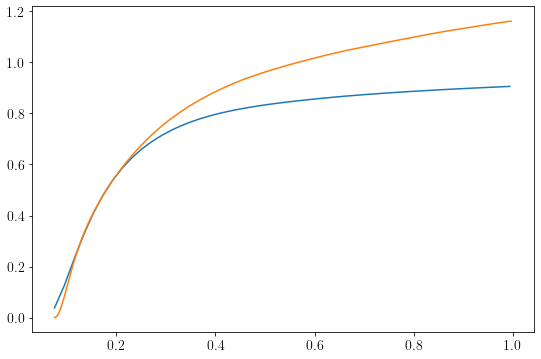

In [88]:
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({'font.size':14})

fig = plt.figure()
ax = plt.subplot()

tau_corr = np.multiply(range(formt, maxt,step), a/DTS)
ax.plot(tau_corr, autocorr_T)
tau = np.multiply(range(formt, maxt, 1), a/DTS)
ax.plot(tau, sigmapt_avg)
# ax.set_ylim(0,1.5)

In [15]:
step = DTS
# autocorrelator = np.zeros((round(maxt/step), ntp, 3))
autocorrelator = np.zeros((ts+1, ntp, 3))
autocorr_t = np.zeros((ntp, 3))

# print(maxt)
# for t0 in range(0, maxt, step):
for t0 in range(0, maxt, step):
    t0_step = int(t0/step)
    # print(t0)
    # for deltat in range(0,maxt-t0, step):
    #     t1 = t0 + deltat
    #     fcorr.compute_lorentz_force_autocorrelator(fs[t0, :, :, :], fs[t1, :, :, :], ws[t0, :, :], ws[t1, :, :])
    #     autocorr_t += fcorr.auto_corr.copy().real
    for t1 in range(0, maxt, step):
        t1_step = int(t1/step)
        # fcorr.compute_lorentz_force_autocorrelator(fs[t0, :, :, :], fs[t1, :, :, :], ws[t0, :, :], ws[t1, :, :])
        fcorr.compute_lorentz_force_autocorrelator(fs[t0_step, :, :, :], fs[t1_step, :, :, :], ws[t0_step, :, :], ws[t1_step, :, :])
        autocorr_t += fcorr.auto_corr.copy().real 
        # autocorrelator[int(t0/step), :, :] += fcorr.auto_corr.copy().real 

    # print(t0)
    # print(autocorr_t)
    autocorrelator[int(t0/step), :, :] = autocorr_t 

autocorr_avg = np.mean(autocorrelator, axis=1)

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({'font.size':14})

fig = plt.figure()
ax = plt.subplot()

labels = [r'$\langle\mathcal{F}_x\mathcal{F}_x\rangle$', r'$\langle\mathcal{F}_y\mathcal{F}_y\rangle$', r'$\langle\mathcal{F}_\eta \mathcal{F}_\eta\rangle$']
# for i in range(2):
    # ax.plot(range(maxt), autocorr_avg[:, i], label=labels[i])
    # ax.plot(range(round(maxt/step)), autocorr_avg[:, i], label=labels[i])
sigmapt = (autocorr_avg[:, 1]+autocorr_avg[:, 2])
ax.plot(range(round(maxt/step)), sigmapt)

# ax.legend()

In [12]:
quark = 'massive'  
p['MASS'] = 10000      
# quark = 'beauty'  
# p['MASS'] = 4.18    
p['TFORM'] = 1/(2*p['MASS'])*hbarc 
tau_sim = 1.0
p['pT'] = 5.0

from tqdm import tqdm

p['FOLDER'] = 'trial'
ev = 0

# Path where results are saved
current_path = os.getcwd() 
results_folder = 'results'
if not os.path.isdir(results_folder):
    os.makedirs(results_folder)
os.chdir(current_path + '/' + results_folder)

# Simulation routine
output = {}
output["parameters"] = p.copy()

# Derived parameters
a = L / N
E0 = N / L * hbarc
DT = 1.0 / DTS
formt = int(p['TFORM'] / a * DTS)
maxt = int(tau_sim / a * DTS)

# Initialize Glasma fields
s = core.Simulation(N, DT, g)
va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
initial.init(s, va, vb)

# Initialize the Wong solver
wong_solver = wong.WongSolver(s, ntp)
pT = p['PT'] / E0
x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 4)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
mass = p['MASS'] / E0 
m = mass * np.ones(ntp)

for i in range(ntp):
    # Positions
    xT = np.random.rand(2) * s.n
    x0 = [xT[0], xT[1], 0.0]
    # Momenta
    angle = 2*np.pi*np.random.rand(1)
    p0 = [0.0, pT * np.cos(angle), pT * np.sin(angle), 0.0]
    # Charges
    q0 = init_charge()

    x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

wong_solver.initialize(x0s, p0s, q0s, m)

kappa_wong_tforce = kappa_wong.TransportedForce(s, wong_solver, ntp)
kappawongpt, tau =  [], []

kappa_tforce = kappa.TransportedForce(s)
kappapt =  []

if use_cuda:
    s.copy_to_device()
    kappa_tforce.copy_to_device()
    kappa_wong_tforce.copy_to_device()

sigmapt_avg = np.zeros(maxt-formt)
# ps = np.zeros((maxt-formt, ntp, 4))

with tqdm(total=maxt) as pbar:
    for t in range(maxt):
        # Evolve Glasma fields
        core.evolve_leapfrog(s)

        # Solve Wong's equations
        if t>=formt:  
            if t % DTS == 0:
                if use_cuda:
                    kappa_wong_tforce.copy_mean_to_host()
                    kappa_tforce.copy_mean_to_host()

                px_kappa, py_kappa = kappa_wong_tforce.p_perp_mean[0], kappa_wong_tforce.p_perp_mean[1]
                kappawongpt.append((px_kappa + py_kappa) * E0 ** 2)
                tau.append(t*a/DTS)

                px_kappa, py_kappa = kappa_tforce.p_perp_mean[0], kappa_tforce.p_perp_mean[1]
                kappapt.append((px_kappa + py_kappa) * E0 ** 2)
                
                if use_cuda:
                    kappa_wong_tforce.copy_mean_to_device()
                    kappa_tforce.copy_mean_to_device()

            kappa_wong_tforce.compute(wong_solver)
            kappa_tforce.compute()

            wong_solver.evolve()

            if t==formt:
                pmu0 = wong_solver.p.copy()
                px0, py0 = pmu0[:, 1], pmu0[:, 2]
            pmu = wong_solver.p.copy()
            px, py = pmu[:, 1], pmu[:, 2]
            sigmapt = (px-px0)**2 + (py-py0)**2
            sigmapt_avg[t-formt] = np.mean(sigmapt) * E0**2
            # ps[t-formt] = wong_solver.p.copy()

        pbar.set_description("Event " + str(ev+1))
        pbar.update(1)


Event 1: 100%|██████████| 409/409 [00:27<00:00, 14.80it/s]


In [5]:
sigmapts = []
for i in range(ntp):
    spt = (ps[:, i, 1]-ps[0, i, 1])**2 + (ps[:, i, 2]-ps[0, i, 2])**2
    sigmapts.append(spt)
sigmapt = np.mean(sigmapts, axis=0)

NameError: name 'ps' is not defined

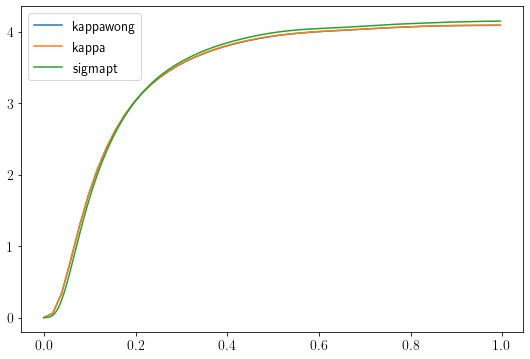

In [13]:
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({'font.size':14})

fig = plt.figure()
ax = plt.subplot()

# ax.plot(tau, np.multiply(kappawongpt, 1/3), label='kappawong')
ax.plot(tau, kappawongpt, label='kappawong')
ax.plot(tau, kappapt, label='kappa')
tau_sigmapt = np.multiply(range(formt, maxt, 1), a/DTS)
ax.plot(tau_sigmapt, sigmapt_avg, label='sigmapt')
fig.patch.set_facecolor('white')
ax.legend()

## Plot the results using Makie from Julia

In [ ]:
using Pickle

file = "results/lorentz_force_correlators.pickle"
data = Pickle.npyload(file)

quarks, pTs = data["quarks"], data["pTs"]
lf_corr, tau = data["corr"], data["tau"]

In [ ]:
# Save data to file

# format_header = "tau [fm/c]\t correlator [GeV^2/fm^2]"
# format_string = "%.8f\t %.8f"
# tags = ['charm_pT_0.5', 'beauty_pT_0.5']

# for tag in tags:
#     filename = 'force_corr_' + tag + '.dat'
#     np.savetxt(filename, np.transpose([taus[tag], corrs_avg[tag]]), header=format_header, fmt=format_string)

## Plot the results using Matplotlib from Python

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

plt.rcParams['text.latex.preamble'] = r'\usepackage{mathrsfs}'
plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({'font.size':14})

fig = plt.figure()
ax = plt.subplot()
# plt.title(r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}\,\,\,\mathrm{SU(3)}\,\,\,p_T^{\mathrm{HQ}s}=0.5\,\mathrm{GeV}$', size = 18)
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 20)
plt.ylabel(r'$\langle \mathscr{F}(\tau_\mathrm{form})\mathscr{F}(\tau)\rangle\,\mathrm{[GeV^2/fm^2]}$', size = 20)

fig.patch.set_facecolor('white')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray') 
ax.tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)
ax.xaxis.grid(True, which='minor')
ax.yaxis.grid(True, which='minor')
ax.grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)
ax.grid(b=True, which='minor', color='silver', alpha=0.2)

colors = ['#8FBCBB', '#A3BE8C', '#B48EAD']
linestyles = ['-', '-.', '--']
iq = 0
for quark in quarks:
    ipT = 0
    for pT in pTs:
        tag = quark + '_pT_' + str(pT)
        ax.plot(correlators['tau'][tag], correlators['corr'][tag], color=colors[ipT], linewidth = 2.5, linestyle=linestyles[iq])
        ipT += 1
    iq += 1

labels_pTs = [r'$0.5$', r'$5.0$', r'$10.0$']
labels_quarks = [r'$\mathrm{Massive}$', r'$\mathrm{Beauty}$', r'$\mathrm{Charm}$']
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1, 2]], labels_pTs, loc = 'upper right', ncol=1, bbox_to_anchor=(0.94,0.97), title=r'$p_T\,\mathrm{[GeV]}$', fontsize='16')
legend1.get_frame().set_boxstyle('square')
legend1.get_title().set_fontsize('18')
legend1.get_frame().set_alpha(0.6)
ax.add_artist(legend1)
legend2 = plt.legend([lines[i] for i in [0, 3, 6]], labels_quarks, loc = 'upper right', ncol=1, bbox_to_anchor=(0.72,0.97), title=r'$\mathrm{Heavy\,quark}$', fontsize='16')
legend2.get_frame().set_boxstyle('square')
legend2.get_title().set_fontsize('18')
legend2.get_frame().set_alpha(0.6)
ax.add_artist(legend2)

ax.set_xlim(0, 1.0)
# ax.set_ylim(0, 14)
# ax.yaxis.set_major_locator(MultipleLocator(4))
# ax.yaxis.set_minor_locator(MultipleLocator(2))
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.get_major_ticks()[1].label1.set_visible(False)

plt.tight_layout()
# plt.savefig('force_corr_charm_vs_beauty.png', dpi=300, facecolor='white', transparent=False)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

plt.rcParams['text.latex.preamble'] = r'\usepackage{mathrsfs}'
plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({'font.size':14})

fig = plt.figure()
ax = plt.subplot()
plt.title(r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}\,\,\,\mathrm{SU(3)}\,\,\,\mathrm{Charm\,Quarks}$', size = 18)
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 20)
plt.ylabel(r'$\langle \mathscr{F}(\tau_\mathrm{form})\mathscr{F}(\tau)\rangle\,\mathrm{[GeV^2/fm^2]}$', size = 20)

ax.xaxis.set_major_locator(MultipleLocator(0.25))
ax.xaxis.set_minor_locator(MultipleLocator(0.125))
ax.yaxis.set_major_locator(MultipleLocator(240))
ax.yaxis.set_minor_locator(MultipleLocator(120))

fig.patch.set_facecolor('white')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray') 
ax.tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)
ax.xaxis.grid(True, which='minor')
ax.yaxis.grid(True, which='minor')
ax.grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)
ax.grid(b=True, which='minor', color='silver', alpha=0.2)

ax.plot(taus['charm_pT_0.5'], corrs_avg['charm_pT_0.5'], color='#81A1C1', linewidth = 2.5, label=r'$0.5\hspace{2.4em}0.0305$')
ax.plot(taus['charm_pT_5.0'], corrs_avg['charm_pT_5.0'], color='#A3BE8C', linewidth = 2.5, label=r'$5.0\hspace{2.4em}0.0206$')
ax.plot(taus['charm_pT_10.0'], corrs_avg['charm_pT_10.0'], color='#B48EAD', linewidth = 2.5, label=r'$10.0\hspace{2em}0.0205$')

leg = ax.legend(fontsize = 16, loc = 'upper right', ncol=1, bbox_to_anchor=(0.94,0.94), title=r'$p_T\,\mathrm{[GeV]}\,\mathrm{with}\,\tau_\mathrm{decay}\,\mathrm{[fm/c]}$')
leg.get_frame().set_boxstyle('square')
leg.get_title().set_fontsize('18')

plt.tight_layout()
# plt.savefig('force_corr_charm_pTs.png', dpi=300, facecolor='white', transparent=False)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

plt.rcParams['text.latex.preamble'] = r'\usepackage{mathrsfs}'
plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({'font.size':14})

fig = plt.figure()
ax = plt.subplot()
plt.title(r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}\,\,\,\mathrm{SU(3)}\,\,\,\mathrm{Beauty\,Quarks}$', size = 18)
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 20)
plt.ylabel(r'$\langle \mathscr{F}(\tau_\mathrm{form})\mathscr{F}(\tau)\rangle\,\mathrm{[GeV^2/fm^2]}$', size = 20)

ax.xaxis.set_major_locator(MultipleLocator(0.25))
ax.xaxis.set_minor_locator(MultipleLocator(0.125))
ax.yaxis.set_major_locator(MultipleLocator(240))
ax.yaxis.set_minor_locator(MultipleLocator(120))

fig.patch.set_facecolor('white')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray') 
ax.tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)
ax.xaxis.grid(True, which='minor')
ax.yaxis.grid(True, which='minor')
ax.grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)
ax.grid(b=True, which='minor', color='silver', alpha=0.2)

ax.plot(taus['charm_pT_0.5'], corrs_avg['charm_pT_0.5'], color='#81A1C1', linewidth = 2.5, label=r'$0.5\hspace{2.4em}0.0305$')
ax.plot(taus['charm_pT_5.0'], corrs_avg['charm_pT_5.0'], color='#A3BE8C', linewidth = 2.5, label=r'$5.0\hspace{2.4em}0.0206$')
ax.plot(taus['charm_pT_10.0'], corrs_avg['charm_pT_10.0'], color='#B48EAD', linewidth = 2.5, label=r'$10.0\hspace{2em}0.0205$')

leg = ax.legend(fontsize = 16, loc = 'upper right', ncol=1, bbox_to_anchor=(0.94,0.94), title=r'$p_T\,\mathrm{[GeV]}\,\mathrm{with}\,\tau_\mathrm{decay}\,\mathrm{[fm/c]}$')
leg.get_frame().set_boxstyle('square')
leg.get_title().set_fontsize('18')

plt.tight_layout()
# plt.savefig('force_corr_charm_pTs.png', dpi=300, facecolor='white', transparent=False)